In [1]:
import numpy as np
import scipy.io as sio
import ase
from ase.io import read
from lib import ase_view, traj_view
import matplotlib.pyplot as plt
from ipywidgets import *

# Introduction et rappels de math

Une fonction affine est une fonction de la forme:
\begin{align}
f(x)=ax+b
\end{align}

Supposons que nous étudions une propriété physique $y$ qui dépend linéairement d'une autre propriété $x$.

La fonction ci-dessous génére un nombre alétaire $a\in [low;high]$

In [2]:
def rand_in(low,high):
    return (high-low)*np.random.random()+low

Définir un vecteur $x$ contenant une dizaine de valeurs aléatoire dans l'interval $[0;1]$, une fonction affine avec $b=0$ et $a \in [1;5]$ généré aléatoirement.
Calculer $y=f(x)$ et tracer les points (x,y) avec la fonction plt.scatter. 

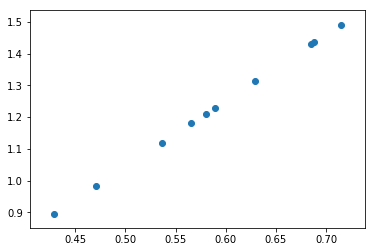

In [3]:
a=rand_in(5,1)
x=np.random.random(10)
y=a*x
plt.scatter(x,y)
plt.show()

Retrouver la valeur de $a$ à partir des valeurs de $x$ et $y$ (sans faire "print(a)"!!).
Pour vérifier, tracer la ligne représentant la fonction affine $f(x)=ax$ avec plt.plot, en plus des points (x,y).

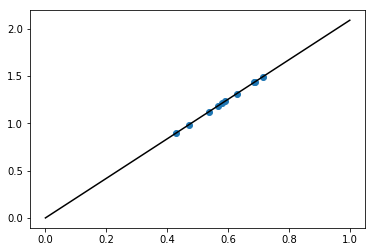

In [4]:
pente=(y[0]/x[0])
xx=np.linspace(0,1,10)
yy=pente*xx
plt.plot(xx,yy, color='k')
plt.scatter(x,y)
plt.show()

Dans la réalité, les choses ne collent pas aussi bien... $f$ ne représente pas paraitement la réalité, c'est un modèle. D'autres facteurs peuvent affecter les valeurs de $y$. 

Ajouter artifiellement du bruit aux données: 
Génerer une autre pente $a$, des points x aléatoires, et des valeurs
$y=ax+as$ ou s est un nombre aléatoire entre $-0.2$ et $0.2$ (différent pour chaque valeur de x).

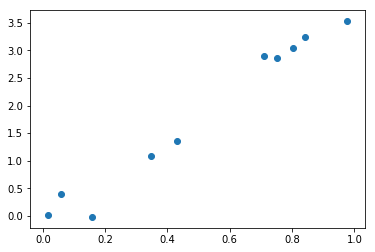

In [23]:
a=rand_in(1,5)
x=np.random.random(10)
y=a*x+a*np.array([rand_in(-0.2,0.2) for i in range(len(x))])
plt.scatter(x,y)
plt.show()

Faire glisser la barre ci-dessous pour changer la pente de la droite tracée et estimer la nouvelle valeur de $a$.

In [24]:
## here they can use the slider to change the slope of the line until it fits the points best
@interact(a=2)
def plot_line(a):
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.scatter(x,y)
    xx=np.linspace(0,1,3)
    ax.plot(xx,a*xx)
    plt.show()
    return

A Jupyter Widget

"Estimer la valeur de la pente", c'est en fait efectuer un régression linéaire, et il y a des méthodes systématiques pour y arriver.

'''Theory on Linear regression''' 


Écrire une fonction "cost" qui calcule la somme des différence entre les valeurs mesurées $y$ et des valeurs à comparer yn

In [29]:
def cost(yn, y):
    return np.sum(np.square(y**2-yn**2))
print(cost(4*x, y),cost(3*x, y)) 

12.3017772544 69.1423380989


Écrire une fonction qui, à partir d'une list de pentes à essayer et des points $x$ et $y$ , trouve la meilleures pente dans la liste, c'est à dire celle qui donne le plus petit coût.

In [32]:
def best_slope(a_list,x,y):
    return min(a_list, key=lambda z: cost(z*x,y))
print(best_slope([3.0,3.5,4,4.5],x,y),best_slope([3.8,3.9,4,4.1,4.2],x,y))

4 3.8


Nous allons effectuer une régression linéaire simplifier come suit:
- Partir d'un interval donné. 
- Prendre $N$ valeur de pente equidistantes dans cette interval.
- Trouver la meilleure 
- Recommencer en prenant comme nouvel interval celui défini par les 2 valeurs de pente autour de la meilleure 
L'algorithme s'arretera lorsque on sait que la leilleure pente se trouve dans un interval plus petit qu'une certaine tolérance.

Est-t-il une bonne idée de prendre $N$ grand? 

In [42]:
def Da(rng, N):
    return abs(rng[1]-rng[0])/N
def simple_lreg(x,y,thr, init_rng, N):
    rng=init_rng
    count=0
    while Da(rng,N) > thr:
        alist=np.linspace(rng[0],rng[1],N)
        ba=best_slope(alist,x,y)
        count+=len(alist)
        rng=[ba-Da(rng,N),ba+Da(rng,N)]
    print("after trying ",count," slopes")
    return ba, count

In [43]:
simple_lreg(x,y,0.0001,[1.,5.],7)

after trying  49  slopes


3.7624090869167328

In [45]:
simple_lreg(x,y,0.0001,[1.,5.],50)

after trying  150  slopes


3.7625795918367344